In [1]:
import pandas as pd
import numpy as np
import cupy as cp

import time
import requests
import datetime 
import logging
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append('C:/Users/dohyu/Desktop/Github/side_proj_fifa')

import matplotlib.pyplot as plt 
import matplotlib as mpl

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns 
import scipy.stats as stats

import xgboost as xgb
import sqlalchemy

from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def db_conn(_username, _password, _host, _port, _database) : 
    db_engine = sqlalchemy.engine.URL.create(
        drivername = "mysql+pymysql",
        username = _username,
        password = _password,
        host = _host,
        port = _port,
        database = _database,
    )

    return create_engine(db_engine)

In [36]:
engine = db_conn('root', 'Dhyoon96!', '127.0.0.1', 3306, 'side_proj_fco')
df_query = 'SELECT * FROM match_user'

with engine.connect() as connection:
    df1 = pd.read_sql(df_query, con = connection)

position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

# df2 = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 
#                           'match_avg_rating', 'match_total_goal',
#                           'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
#                           'match_total_shoot', 'match_total_shoot_eff', 
#                           'match_total_pass_short_suc', 
#                           'match_total_pass_through_suc', 
#                           'match_total_pass_long_suc', 
#                           'match_total_shoot_outpenalty_suc', 
#                           'match_total_shoot_inpenalty_suc']
#                           + position_ratings_col)

# Get columns from match_user_visualization VIF Check
df_col_temp = ['match_result'] + ['match_total_pass_short_suc',
                                  'match_total_pass_long_suc',
                                  'match_total_pass_through_try',
                                  'match_total_shoot_outpenalty_try',
                                  'match_total_shoot_outpenalty_suc',
                                  'match_total_shoot_inpenalty_try',
                                  'match_total_shoot_inpenalty_suc']

df2 = df1[((df1['match_result'] == '승') | (df1['match_result'] == '패'))]
df2 = df2[df2['match_endtype'] == 0]

In [38]:
df2[df_col_temp]

,match_result,match_total_pass_short_suc,match_total_pass_long_suc,match_total_pass_through_try,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
0,승,47,10,23,1,1,7,4
2,승,29,4,36,7,1,5,2
3,패,60,2,13,3,1,4,1
8,패,92,3,20,2,0,7,2
9,승,74,2,20,2,1,6,2
...,...,...,...,...,...,...,...,...
432,승,62,3,16,4,0,5,1
433,패,81,2,23,7,1,7,0
434,승,51,4,20,2,1,5,3
441,패,77,0,40,1,1,2,0


In [39]:
df2 = df2[df_col_temp]
df2['match_result'] = df2['match_result'].map({'승': 1, '패': 0})

X = df2.drop('match_result', axis = 1)
y = df2['match_result']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = y)

scaler = MinMaxScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
X_test_scaled = scaler.transform(X_test)

X_temp_scaled_gpu = cp.array(X_temp_scaled)
X_test_scaled_gpu = cp.array(X_test_scaled)
y_temp_gpu = cp.array(y_temp)
y_test_gpu = cp.array(y_test)

# RandomForest Classifier

In [51]:
model_rcf = RandomForestClassifier(random_state = 42)

kf_rcf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

param_grid_rcf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rcf = GridSearchCV(estimator = model_rcf, 
                           param_grid = param_grid_rc, 
                           cv = kf_rcf, 
                           n_jobs = -1, 
                           verbose = 2)

In [52]:
grid_search_rcf.fit(X_temp_scaled, y_temp)

best_model_rcf = grid_search_rcf.best_estimator_

y_test_pred_rcf = best_model_rcf.predict(X_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_rcf))
print("\nClassification Report on Test Set_RCF:\n", classification_report(y_test, y_test_pred_rcf))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Test Accuracy: 0.8615384615384616

Classification Report on Test Set_RCF:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.85      0.88      0.87        33

    accuracy                           0.86        65
   macro avg       0.86      0.86      0.86        65
weighted avg       0.86      0.86      0.86        65



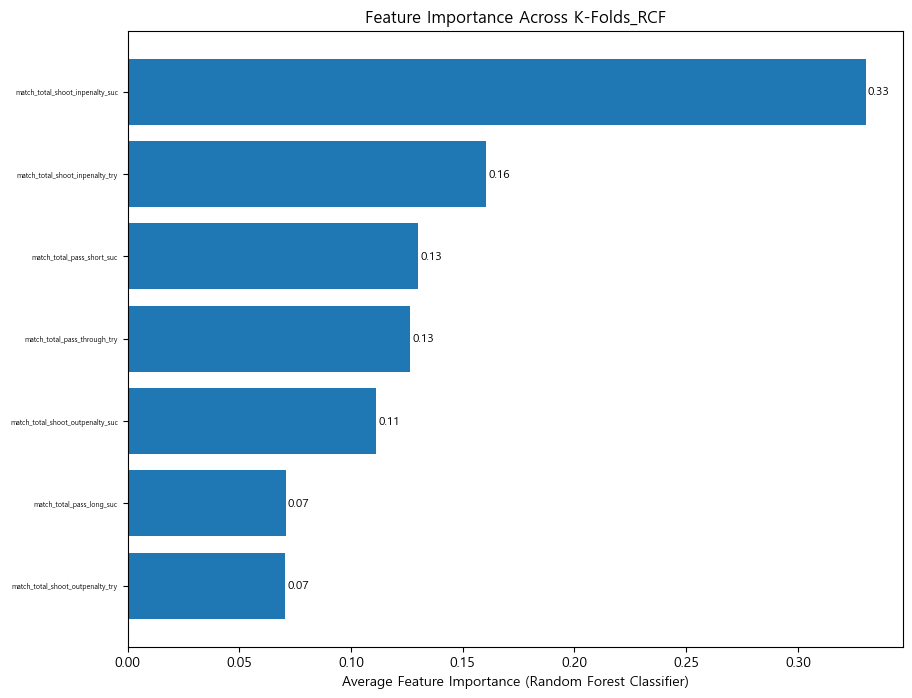

In [54]:
feature_importance_avg_rcf = best_model_rcf.feature_importances_
sorted_idx_rcf = feature_importance_avg_rcf.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx_rcf], feature_importance_avg_rcf[sorted_idx_rcf])
plt.xlabel("Average Feature Importance (Random Forest Classifier)")
plt.title("Feature Importance Across K-Folds_RCF")

plt.tick_params(axis = 'y', labelsize = 5)  
plt.tick_params(axis = 'x') 

for i, v in enumerate(feature_importance_avg_rcf[sorted_idx_rcf]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

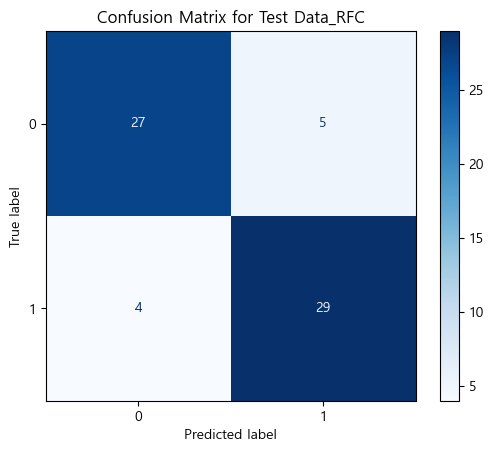

In [55]:
test_result_rc = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred_rc
})

cm_rc = confusion_matrix(y_test, y_test_pred_rc)

disp_rc = ConfusionMatrixDisplay(confusion_matrix = cm_rc, display_labels = best_model_rc.classes_)
disp_rc.plot(cmap = 'Blues', values_format = 'd')
plt.title("Confusion Matrix for Test Data_RFC")
plt.show()

# XGBoost Classifier with K-fold, GridSearch

In [46]:
model_xgb = xgb.XGBClassifier(
    tree_method = 'gpu_hist',  
    eval_metric = "logloss",
    use_label_encoder = False,  
    random_state = 42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]}

kf_xgb = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_xgb = GridSearchCV(estimator = model_xgb, 
                               param_grid = param_grid_xgb, 
                               cv = kf_xgb, 
                               verbose = 1, 
                               n_jobs = -1)

In [47]:
grid_search_xgb.fit(X_temp_scaled_gpu.get(), y_temp_gpu.get())

print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best cross-validation score: ", grid_search_xgb.best_score_)

best_model_xgb = grid_search_xgb.best_estimator_

y_test_pred_xgb = best_model_xgb.predict(X_test_scaled_gpu.get())

print("\nTest Accuracy:", accuracy_score(y_test_gpu.get(), y_test_pred_xgb))
print("\nClassification Report on Test Set:\n", classification_report(y_test_gpu.get(), y_test_pred_xgb))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score:  0.7607843137254902

Test Accuracy: 0.8307692307692308

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.82      0.85      0.84        33

    accuracy                           0.83        65
   macro avg       0.83      0.83      0.83        65
weighted avg       0.83      0.83      0.83        65



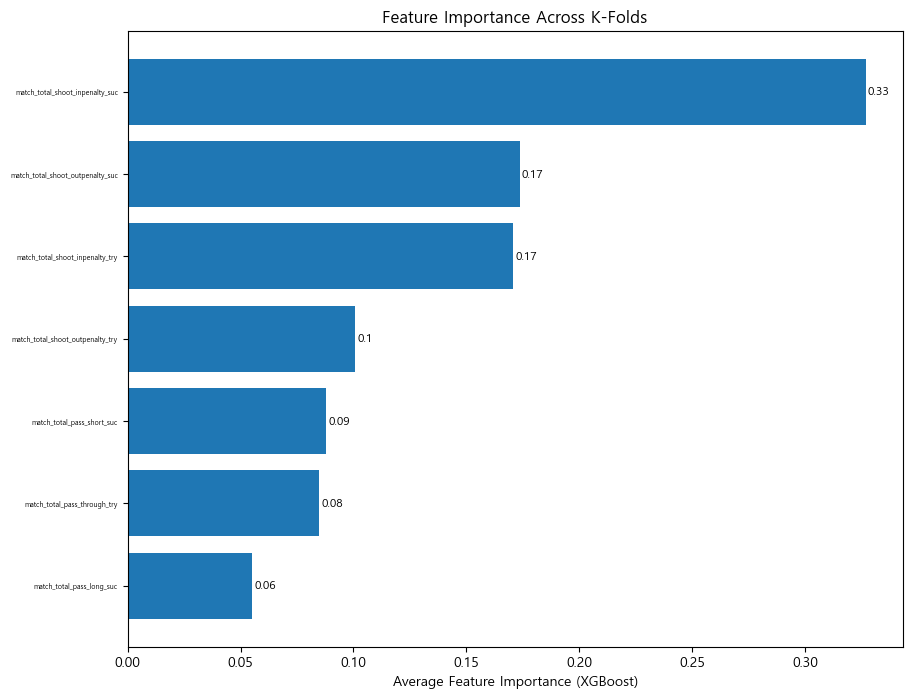

In [48]:
feature_importance_avg_xgb = best_model_xgb.feature_importances_
sorted_idx_xgb = feature_importance_avg_xgb.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx_xgb], feature_importance_avg_xgb[sorted_idx_xgb])
plt.xlabel("Average Feature Importance (XGBoost)")
plt.title("Feature Importance Across K-Folds")

plt.tick_params(axis = 'y', labelsize = 5)  
plt.tick_params(axis = 'x')  

for i, v in enumerate(feature_importance_avg_xgb[sorted_idx_xgb]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

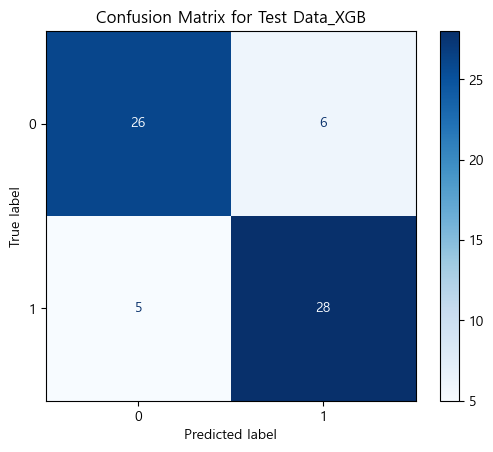

In [49]:
test_result_xgb = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred_xgb
})

cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

disp_rc = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = best_model_xgb.classes_)
disp_rc.plot(cmap = 'Blues', values_format = 'd')
plt.title("Confusion Matrix for Test Data_XGB")
plt.show()